# Studying Stock Returns vs Social Sentiments

Are stock returns and social sentiments related? What is the relationship if we expect one?

And more importantly, could we use social sentiments to predict stock returns?

In this study, we will quickly look at **Social Sentiments** on **Tweets** using the `TextBlob` and `Vadar` package. And we will compare daily sentiments with daily stock returns.

The **Stock returns** in question actually would be the [**Alpha**](https://corporatefinanceinstitute.com/resources/knowledge/finance/alpha/) of the stock, where

$$ \alpha = {R}-{Rf}- \beta ({Rm} - {Rf}) $$

for our purpose, we are going to assume that ${Rf}$ is 0

### Preliminary
For this study, we will use `pandas_datareader` to get historical returns;

And `vaderSentiment` and `TextBlob` for Sentiment Analysis

In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import re
from unidecode import unidecode
import time

# sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from datetime import timedelta

# pandas data reader
import pandas_datareader.data as web
from datetime import datetime as dt
from scipy.stats import pearsonr

# Alpha Vantage requirements
av_api_key = 'TGXS2LEUKMHXTKT5'
from alpha_vantage.timeseries import TimeSeries
ts = TimeSeries( key = av_api_key, output_format = 'pandas')

# plotting
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
# Required for Plot.ly Offline
init_notebook_mode(connected=True)
# Cufflinks bind plotly to pandas dataframe in IPython Notebooks
cf.set_config_file(offline = False, world_readable = True, theme = 'ggplot')

## Getting Stock Returns
for our study, we are interested in the [**FANG** stocks](https://www.investopedia.com/terms/f/fang-stocks-fb-amzn.asp): `FB`, `AMZN`, `NFLX`, [`GOOG`](https://investorplace.com/2019/01/goog-google-stock-split/)

The [relevant benchmark would then be NASDAQ](https://www.forbes.com/sites/jaysomaney/2016/12/30/comparing-facebook-amazon-netflix-and-google-aka-fang-performance-in-2016/#57a2bf8952f9), which we'll use `QQQ` as proxy for.

We'll also get `SPY` just to test our calculated **Beta** vs Yahoo! Finance. The calcuation is reference from [here](https://medium.com/python-data/capm-analysis-calculating-stock-beta-as-a-regression-in-python-c82d189db536)

In [2]:
l_symbols = ['FB','AMZN', 'NFLX', 'GOOG', 'QQQ', 'SPY']
sdate = dt(2018,1,1)
edate = dt(2019,1,23)
yhoo_data = web.DataReader( l_symbols, 'yahoo', sdate, edate)

In [3]:
yhoo_data.head()

Attributes         High                                                   \
Symbols            AMZN          FB         GOOG        NFLX         QQQ   
Date                                                                       
2018-01-02  1190.000000  181.580002  1066.939941  201.649994  158.529999   
2018-01-03  1205.489990  184.779999  1086.290039  206.210007  160.169998   
2018-01-04  1215.869995  186.210007  1093.569946  207.050003  160.789993   
2018-01-05  1229.140015  186.899994  1104.250000  210.020004  162.029999   
2018-01-08  1253.079956  188.899994  1111.270020  212.500000  162.630005   

Attributes                      Low                                       \
Symbols            SPY         AMZN          FB         GOOG        NFLX   
Date                                                                       
2018-01-02  268.809998  1170.510010  177.550003  1045.229980  195.419998   
2018-01-03  270.640015  1188.300049  181.330002  1063.209961  201.500000   
2018-01-04  272.160004  1204.660034  184.100006  1084.001953  204.000000   
2018-01-05  273.559998  1210.000000  184.929993  1092.000000  205.589996   
2018-01-08  274.100006  1232.030029  186.330002  1101.619995  208.440002   

Attributes     ...         Volume                                      \
Symbols        ...           GOOG        NFLX         QQQ         SPY   
Date           ...                                                      
2018-01-02     ...      1237600.0  10966900.0  32573300.0  86655700.0   
2018-01-03     ...      1430200.0   8591400.0  29383600.0  90070400.0   
2018-01-04     ...      1004600.0   6029600.0  24776100.0  80636400.0   
2018-01-05     ...      1279100.0   7033200.0  26992300.0  83524000.0   
2018-01-08     ...      1047600.0   5580200.0  23159100.0  57319200.0   

Attributes    Adj Close                                                   \
Symbols            AMZN          FB         GOOG        NFLX         QQQ   
Date                                                                       
2018-01-02  1189.010010  181.419998  1065.000000  201.070007  157.162064   
2018-01-03  1204.199951  184.669998  1082.479980  205.050003  158.689163   
2018-01-04  1209.589966  184.330002  1086.400024  205.630005  158.966827   
2018-01-05  1229.140015  186.850006  1102.229980  209.990005  160.563324   
2018-01-08  1246.869995  188.279999  1106.939941  212.050003  161.188049   

Attributes              
Symbols            SPY  
Date                    
2018-01-02  263.759949  
2018-01-03  265.428253  
2018-01-04  266.546997  
2018-01-05  268.323273  
2018-01-08  268.813934  

[5 rows x 36 columns]

In [4]:
data = yhoo_data.stack()
data.reset_index(inplace = True)

l_col_to_keep = ['Date', 'Symbols', 'Adj Close', 'Volume']
r_dfs = []

# 1
for sym in l_symbols:
    r_df = data[ data.Symbols == sym ].loc[:, l_col_to_keep]
    r_df = r_df.set_index('Date')
    r_df[f'r({sym})'] = r_df['Adj Close']/ r_df['Adj Close'].shift(1) - 1
    # or just do df.pct_change()
    r_dfs.append( r_df.iloc[1:,:])

# 2
df = reduce( lambda x, y : pd.concat([x,y], axis =1),
            [ r_df.iloc[:,-1] for r_df in r_dfs ]
           )

df.sort_values(by = 'Date',ascending = False).head(3)

,r(FB),r(AMZN),r(NFLX),r(GOOG),r(QQQ),r(SPY)
Date,,,,,,
2019-01-23,-0.022159,0.004810,-0.009749,0.004717,0.001297,0.002092
2019-01-22,-0.016462,-0.037749,-0.041109,-0.025258,-0.020030,-0.013510
2019-01-18,0.011733,0.001760,-0.039894,0.007670,0.009900,0.013310


In [9]:
from scipy import stats
def GetBeta( r_sym , r_benchmark):
    slope, intercept, r_value, p_value, std_err = stats.linregress( r_sym, r_benchmark)
    return slope

def GetAlpha( r_sym , r_benchmark):
    beta = GetBeta( r_sym, r_benchmark)
    return r_sym - beta * r_benchmark

In [10]:
GetBeta( df['r(FB)'], df['r(QQQ)'])

0.4091781041940176

In [11]:
alpha_fb = GetAlpha( df['r(FB)'], df['r(QQQ)'])
alpha_fb.sort_index(ascending= False).head()

Date
2019-01-23   -0.022690
2019-01-22   -0.008266
2019-01-18    0.007682
2019-01-17    0.001925
2019-01-16   -0.009391
dtype: float64

### Visualizing **Alpha**, **${Rm}$**, **${R}$**

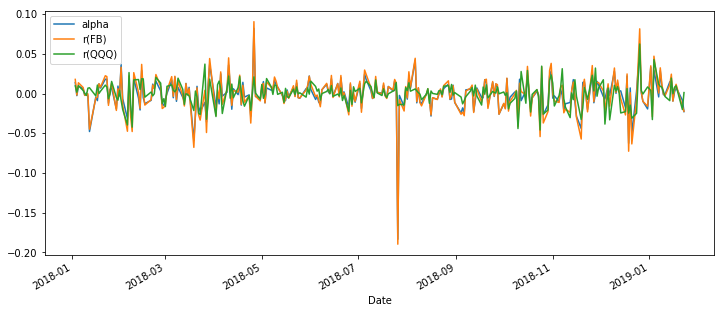

In [12]:
cols = ['alpha','r(FB)', 'r(QQQ)']
l_series = [alpha_fb, df['r(FB)'], df['r(QQQ)']]
plot_df = pd.concat( l_series, axis = 1)
plot_df.columns = cols
#plot_df = pd.DataFrame(data = l_series, columns = cols, index = alpha_fb.index)
plot_df.plot(figsize = (12,5))

In [13]:
plotly_data = [go.Scatter(x = plot_df.index, y = plot_df['alpha'], name = 'alpha'), 
               go.Scatter(x = plot_df.index, y = plot_df['r(FB)'], name = 'r(FB)'),
               go.Scatter(x = plot_df.index, y = plot_df['r(QQQ)'],name = 'r(QQQ)')
              ]
iplot(plotly_data)

In [14]:
# getting alpha
alpha_fb   = GetAlpha( df['r(FB)'], df['r(QQQ)'])
alpha_amzn = GetAlpha( df['r(AMZN)'], df['r(QQQ)'])
alpha_nflx = GetAlpha( df['r(NFLX)'], df['r(QQQ)'])
alpha_goog = GetAlpha( df['r(GOOG)'], df['r(QQQ)'])

## Getting Twitter Sentiments 

In this section, we will calculate the correlation (Pearson's correlation cofficient) between the sentiment towards the `FANG` stocks and alpha. For the sources of the sentiment data, we have scraped them from twitter, reddit and news. 

We do the analysis on those tweets first.

In [15]:
t_nflx = pd.read_csv('dataset/twitter/NFLX.csv')
t_fb = pd.read_csv('dataset/twitter/FB.csv')
t_amzn = pd.read_csv('dataset/twitter/AMZN.csv')
t_goog = pd.read_csv('dataset/twitter/GOOG.csv')

In [16]:
def data_processing(data, stockcode):
    data = data[['unix_timestamp','content']]
    data = data.dropna()
    
    data['stockcode'] = data['content'].copy()
    data['stockcode'] = data['stockcode'].apply(lambda x: stockcode)
    
    data['vader'] = data['content'].copy()
    data['vader'] = data['vader'].apply(lambda x: str(x).lower())
    data['vader'] = data['vader'].apply(lambda x: unidecode(x))
#     data['vader'] = data['vader'].apply(lambda x: unidecode(re.sub('[^a-zA-z0-9\s\-+\*+\$+https:+http]+','',x)))
    data['textblob'] = data['vader'].copy()
    
    # Generating Vader Sentiment
    analyzer = SentimentIntensityAnalyzer()
    data['vader'] = data['vader'].apply(analyzer.polarity_scores) 
    data['vader'] = data['vader'].apply(lambda x: x['compound']) 
    
    # Generating TextBlob Sentiment
    data['textblob'] = data['textblob'].apply(TextBlob) 
    data['textblob'] = data['textblob'].apply(lambda x: x.sentiment[0])
    
    data['unix_timestamp'] = data['unix_timestamp'].apply(lambda x: str(x)[0:10])
    # EST = GMT - 5 so that we need to change the timestamp
    data['unix_timestamp'] = data['unix_timestamp'].apply(lambda x: (dt.fromtimestamp(int(x)) - timedelta(hours=5)).strftime('%Y-%m-%d %H:%M:%S'))
    data['unix_timestamp'] = pd.to_datetime(data['unix_timestamp'])
    data['date'] = data['unix_timestamp']
    data['date'] = data['date'].apply(time_tuner)
    data.index = data['date']
    del data['date']
    return data.sort_index()

def time_tuner(date):
    
    # define the summer hours in 2018 of the New York Stock Exchange
    summer_time_start = dt.strptime('2018-03-11 01:59:59', "%Y-%m-%d %H:%M:%S")
    summer_time_end   = dt.strptime('2018-11-04 02:00:01', "%Y-%m-%d %H:%M:%S")
    
    # define the trading hours in both summer time and winter time
    sum_open_trade    = dt.strptime('09:29:59', "%H:%M:%S").time()
    sum_close_trade   = dt.strptime('16:00:01', "%H:%M:%S").time()
    win_open_trade    = dt.strptime('10:29:59', "%H:%M:%S").time()
    win_close_trade   = dt.strptime('17:00:01', "%H:%M:%S").time()
    
    # If the tweets were posted within the SUMMER time
    if (date > summer_time_start) and (date < summer_time_end):
        if date.weekday() == 6: 
            date = date + timedelta(days=1) 
            date = date.strftime('%Y-%m-%d')
        elif date.weekday() == 5: 
            date = date + timedelta(days=2)
            date = date.strftime('%Y-%m-%d')
        elif date.weekday() == 4:
            if (date.time() < sum_close_trade) or ((date.time() > sum_open_trade) and (date.time() < sum_close_trade)):
                date = date.strftime('%Y-%m-%d')
            else:
                date = date + timedelta(days=3)
                date = date.strftime('%Y-%m-%d')
        else: 
            if (date.time() < sum_close_trade) or ((date.time() > sum_open_trade) and (date.time() < sum_close_trade)):
                date = date.strftime('%Y-%m-%d')
            else:
                date = date + timedelta(days=1)
                date = date.strftime('%Y-%m-%d')
    
    else:
        if date.weekday() == 6: 
            date = date + timedelta(days=1) 
            date = date.strftime('%Y-%m-%d')
        elif date.weekday() == 5: 
            date = date + timedelta(days=2)
            date = date.strftime('%Y-%m-%d')
        elif date.weekday() == 4:
            if (date.time() < win_close_trade) or ((date.time() > win_open_trade) and (date.time() < win_close_trade)):
                date = date.strftime('%Y-%m-%d')
            else:
                date = date + timedelta(days=3)
                date = date.strftime('%Y-%m-%d')
        else: 
            if (date.time() < win_close_trade) or ((date.time() > win_open_trade) and (date.time() < win_close_trade)):
                date = date.strftime('%Y-%m-%d')
            else:
                date = date + timedelta(days=1)
                date = date.strftime('%Y-%m-%d')
    
    return date

def daily_sentiment_calculator(data):
    data = data[['vader','textblob']].reset_index()
    data = data[['vader','textblob']].groupby(data['date']).sum()
    return data

def get_alpha_tweetsent_table(alpha, data, stockcode):
    """
    alpha: the alpha of the stock
    data : the sentiment data of the stock
    stockcode: just for you to input a stock code
    """
    data = data_processing(data, stockcode)
    data = daily_sentiment_calculator(data)
    data = data.reset_index()
    data.columns = ['Date', 'Vader', 'TextBlob']
    data['Date'] = pd.to_datetime(data['Date'])
    alpha = alpha.reset_index()
    alpha.columns = ['Date','Alpha']
    merge = pd.merge(data, alpha, how='inner', on='Date')
    return merge

def alpha_sent_stat_analysis(table):
    Vader = pearsonr(table['Vader'], table['Alpha'])
    TextBlob = pearsonr(table['TextBlob'], table['Alpha'])
    return {'Vader_corr':round(Vader[0],2), 'Vader_p_value':round(Vader[1],2),
            'TextBlob_corr':round(TextBlob[0],2), 'TextBlob_p_value':round(TextBlob[1],2)}
    
def plot_alpha_corr_vader(table):
    scatterdf = table.dropna()[['Alpha','Vader']]
    plotly_data = [go.Scatter(x = scatterdf.Alpha, y = scatterdf.Vader, 
                              mode = 'markers',
                              marker = dict(size = 10,  
                                            line = dict( width = 2,)
                                           )
                             )]
    layout = go.Layout(title = 'excess return vs sentiments',
                       xaxis = {'title': 'excess return'},
                       yaxis = {'title': 'vader sentiment'})
    fig = go.Figure(data = plotly_data, layout= layout)
    return iplot(fig)

def plot_alpha_corr_textblob(table):
    scatterdf = table.dropna()[['Alpha','TextBlob']]
    plotly_data = [go.Scatter(x = scatterdf.Alpha, y = scatterdf.TextBlob, 
                              mode = 'markers', 
                              marker = dict( size = 10, 
                                            color = 'rgba(255, 182, 193, .9)', 
                                            line = dict( width = 2,)
                                           )
                             )]
    layout = go.Layout(title = 'excess return vs sentiments',
                       xaxis = {'title': 'excess return'},
                       yaxis = {'title': 'textblob sentiment'})
    fig = go.Figure(data = plotly_data, layout= layout)
    return iplot(fig)

### Tweets about NFLX

In [17]:
T_NFLX = get_alpha_tweetsent_table(alpha_nflx, t_nflx, 'NFLX')
print(alpha_sent_stat_analysis(T_NFLX))
plot_alpha_corr_vader(T_NFLX)
plot_alpha_corr_textblob(T_NFLX)

{'Vader_corr': 0.12, 'Vader_p_value': 0.1, 'TextBlob_corr': -0.07, 'TextBlob_p_value': 0.35}


### Tweets about GOOG

In [18]:
T_GOOG = get_alpha_tweetsent_table(alpha_goog, t_goog, 'GOOG')
print(alpha_sent_stat_analysis(T_GOOG))
plot_alpha_corr_vader(T_GOOG)
plot_alpha_corr_textblob(T_GOOG)

{'Vader_corr': -0.08, 'Vader_p_value': 0.3, 'TextBlob_corr': 0.03, 'TextBlob_p_value': 0.69}


### Tweets about AMZN

In [19]:
T_AMZN = get_alpha_tweetsent_table(alpha_amzn, t_amzn, 'AMZN')
print(alpha_sent_stat_analysis(T_AMZN))
plot_alpha_corr_vader(T_AMZN)
plot_alpha_corr_textblob(T_AMZN)

{'Vader_corr': 0.11, 'Vader_p_value': 0.38, 'TextBlob_corr': 0.07, 'TextBlob_p_value': 0.58}


### Tweets about FB

In [20]:
T_FB = get_alpha_tweetsent_table(alpha_fb, t_fb, 'FB')
print(alpha_sent_stat_analysis(T_FB))
plot_alpha_corr_vader(T_FB)
plot_alpha_corr_textblob(T_FB)

{'Vader_corr': 0.02, 'Vader_p_value': 0.87, 'TextBlob_corr': 0.06, 'TextBlob_p_value': 0.59}


## Getting Reddit Sentiments 

In [21]:
r_amzn = pd.read_csv('dataset/reddit/AMZN_reddit_2018_2019.csv')
r_fb   = pd.read_csv('dataset/reddit/FB_reddit_2018_2019.csv')
r_goog = pd.read_csv('dataset/reddit/GOOG_reddit_2018_2019.csv')
r_nflx = pd.read_csv('dataset/reddit/NFLX_reddit_2018_2019.csv')

In [22]:
def reddit_data_processing(data, stockcode):
    data = data[['title','body','created']]
    data = data.dropna()
    
    data['stockcode'] = data['created'].copy()
    data['stockcode'] = data['stockcode'].apply(lambda x: stockcode)
    
    # Conducting Sentiment Analysis on "Body"
    data['vader'] = data['body'].copy()
    data['vader'] = data['vader'].apply(lambda x: str(x).lower())
    data['vader'] = data['vader'].apply(lambda x: unidecode(x))
    data['textblob'] = data['vader'].copy()
    
     # Generating Vader Sentiment
    analyzer = SentimentIntensityAnalyzer()
    data['vader'] = data['vader'].apply(lambda x: analyzer.polarity_scores(str(x))) 
    data['vader'] = data['vader'].apply(lambda x: x['compound']) 
    
    # Generating TextBlob Sentiment
    data['textblob'] = data['textblob'].apply(TextBlob) 
    data['textblob'] = data['textblob'].apply(lambda x: x.sentiment[0])
    
    # Date
    data['created'] = data['created'].apply(lambda x: int(str(x)[0:10]))
    data['created'] = data['created'].apply(lambda x: (dt.fromtimestamp(int(x)) - timedelta(hours=5)).strftime('%Y-%m-%d %H:%M:%S'))
    data['created'] = pd.to_datetime(data['created'])
    data['date'] = data['created'].copy()
    data['date'] = pd.to_datetime(data['date']).apply(time_tuner)
    data.index = data['date']
    del data['date']
    return data.sort_index()

def get_alpha_redditsent_table(alpha, data, stockcode):
    """
    alpha: the alpha of the stock
    data : the sentiment data of the stock
    stockcode: just for you to input a stock code
    """
    data = reddit_data_processing(data, stockcode)
    data = daily_sentiment_calculator(data)
    data = data.reset_index()
    data.columns = ['Date', 'Vader', 'TextBlob']
    data['Date'] = pd.to_datetime(data['Date'])
    alpha = alpha.reset_index()
    alpha.columns = ['Date','Alpha']
    merge = pd.merge(data, alpha, how='inner', on='Date')
    return merge

### Reddit about NFLX

In [23]:
R_NFLX = get_alpha_redditsent_table(alpha_nflx, r_nflx, 'NFLX')
print(alpha_sent_stat_analysis(R_NFLX))
plot_alpha_corr_vader(R_NFLX)
plot_alpha_corr_textblob(R_NFLX)

{'Vader_corr': -0.19, 'Vader_p_value': 0.12, 'TextBlob_corr': -0.24, 'TextBlob_p_value': 0.06}


### Reddit about GOOG

In [24]:
R_GOOG = get_alpha_redditsent_table(alpha_goog, r_goog, 'GOOG')
print(alpha_sent_stat_analysis(R_GOOG))
plot_alpha_corr_vader(R_GOOG)
plot_alpha_corr_textblob(R_GOOG)

{'Vader_corr': 0.01, 'Vader_p_value': 0.93, 'TextBlob_corr': -0.4, 'TextBlob_p_value': 0.0}


### Reddit about AMZN

In [25]:
R_AMZN = get_alpha_redditsent_table(alpha_amzn, r_amzn, 'AMZN')
print(alpha_sent_stat_analysis(R_AMZN))
plot_alpha_corr_vader(R_AMZN)
plot_alpha_corr_textblob(R_AMZN)

{'Vader_corr': 0.06, 'Vader_p_value': 0.6, 'TextBlob_corr': 0.04, 'TextBlob_p_value': 0.69}


### Reddit about FB

In [26]:
R_FB = get_alpha_redditsent_table(alpha_fb, r_fb, 'FB')
print(alpha_sent_stat_analysis(R_FB))
plot_alpha_corr_vader(R_FB)
plot_alpha_corr_textblob(R_FB)

{'Vader_corr': -0.12, 'Vader_p_value': 0.28, 'TextBlob_corr': -0.16, 'TextBlob_p_value': 0.16}


## Getting News Sentiments 

In [27]:
n_amzn = pd.read_csv('dataset/nasdaq/AMZN_nasdaq_news_merged.csv')
n_fb   = pd.read_csv('dataset/nasdaq/FB_nasdaq_news_merged.csv')
n_nflx = pd.read_csv('dataset/nasdaq/NFLX_nasdaq_news_merged.csv')
n_goog = pd.read_csv('dataset/nasdaq/GOOG_nasdaq_news_cleaned.csv')

def nasdaq_data_processing(data, stockcode, Text=False):
    
    if Text:
        data = data[['text','date_EST']]
        data = data.dropna()
        data['vader'] = data['text'].copy()
    else:
        data = data[['title','date_EST']]
        data = data.dropna()
        data['vader'] = data['title'].copy()

    data['vader'] = data['vader'].apply(lambda x: str(x).lower())
    data['vader'] = data['vader'].apply(lambda x: unidecode(x))
    data['textblob'] = data['vader'].copy()
    
    data['stockcode'] = data['date_EST'].copy()
    data['stockcode'] = data['stockcode'].apply(lambda x: stockcode)
    
    # Generating Vader Sentiment
    analyzer = SentimentIntensityAnalyzer()
    data['vader'] = data['vader'].apply(analyzer.polarity_scores) 
    data['vader'] = data['vader'].apply(lambda x: x['compound']) 
    
    # Generating TextBlob Sentiment
    data['textblob'] = data['textblob'].apply(TextBlob) 
    data['textblob'] = data['textblob'].apply(lambda x: x.sentiment[0])
        
    # Datatime 
    data['date_EST'] = pd.to_datetime(data['date_EST']) 
    
    # Date
    data['date'] = data['date_EST'].copy()
    data['date'] = pd.to_datetime(data['date'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S')))
    data['date'] = data['date'].apply(time_tuner)
    data.index = data['date']
    del data['date']
    
    return data.sort_index()

def get_alpha_newsent_table(alpha, data, stockcode, Text=False):
    """
    alpha: the alpha of the stock
    data : the sentiment data of the stock
    stockcode: just for you to input a stock code
    """
    data = nasdaq_data_processing(data, stockcode, Text=Text)
    data = daily_sentiment_calculator(data)
    data = data.reset_index()
    data.columns = ['Date', 'Vader', 'TextBlob']
    data['Date'] = pd.to_datetime(data['Date'])
    alpha = alpha.reset_index()
    alpha.columns = ['Date','Alpha']
    merge = pd.merge(data, alpha, how='inner', on='Date')
    return merge

### News headlines about NFLX

In [28]:
N_NFLX = get_alpha_newsent_table(alpha_nflx ,n_nflx,'NFLX')
print(alpha_sent_stat_analysis(N_NFLX))
plot_alpha_corr_vader(N_NFLX)
plot_alpha_corr_textblob(N_NFLX)

{'Vader_corr': 0.4, 'Vader_p_value': 0.0, 'TextBlob_corr': 0.21, 'TextBlob_p_value': 0.06}


### News headlines about GOOG

In [29]:
N_GOOG = get_alpha_newsent_table(alpha_goog ,n_goog,'GOOG')
print(alpha_sent_stat_analysis(N_GOOG))
plot_alpha_corr_vader(N_GOOG)
plot_alpha_corr_textblob(N_GOOG)

{'Vader_corr': 0.2, 'Vader_p_value': 0.01, 'TextBlob_corr': 0.02, 'TextBlob_p_value': 0.79}


### News headlines about AMZN

In [30]:
N_AMZN = get_alpha_newsent_table(alpha_amzn ,n_amzn,'AMZN')
print(alpha_sent_stat_analysis(N_AMZN))
plot_alpha_corr_vader(N_AMZN)
plot_alpha_corr_textblob(N_AMZN)

{'Vader_corr': 0.27, 'Vader_p_value': 0.04, 'TextBlob_corr': 0.06, 'TextBlob_p_value': 0.64}


### News headlines about FB

In [31]:
N_FB = get_alpha_newsent_table(alpha_fb ,n_fb,'FB')
print(alpha_sent_stat_analysis(N_FB))
plot_alpha_corr_vader(N_FB)
plot_alpha_corr_textblob(N_FB)

{'Vader_corr': 0.23, 'Vader_p_value': 0.03, 'TextBlob_corr': 0.12, 'TextBlob_p_value': 0.25}


### News Text about NFLX

In [32]:
N_NFLX_T = get_alpha_newsent_table(alpha_nflx ,n_nflx,'NFLX', Text=True)
print(alpha_sent_stat_analysis(N_NFLX_T))
plot_alpha_corr_vader(N_NFLX_T)
plot_alpha_corr_textblob(N_NFLX_T)

{'Vader_corr': 0.35, 'Vader_p_value': 0.0, 'TextBlob_corr': 0.27, 'TextBlob_p_value': 0.01}


### News Text about GOOG

In [33]:
N_GOOG_T = get_alpha_newsent_table(alpha_goog ,n_goog,'GOOG', Text=True)
print(alpha_sent_stat_analysis(N_GOOG_T))
plot_alpha_corr_vader(N_GOOG_T)
plot_alpha_corr_textblob(N_GOOG_T)

{'Vader_corr': 0.17, 'Vader_p_value': 0.03, 'TextBlob_corr': 0.09, 'TextBlob_p_value': 0.27}


### News Text about AMZN

In [34]:
N_AMZN_T = get_alpha_newsent_table(alpha_amzn ,n_amzn,'AMZN', Text=True)
print(alpha_sent_stat_analysis(N_AMZN_T))
plot_alpha_corr_vader(N_AMZN_T)
plot_alpha_corr_textblob(N_AMZN_T)

{'Vader_corr': 0.21, 'Vader_p_value': 0.13, 'TextBlob_corr': 0.18, 'TextBlob_p_value': 0.18}


### News Text about FB

In [35]:
N_FB_T = get_alpha_newsent_table(alpha_fb ,n_amzn,'FB', Text=True)
print(alpha_sent_stat_analysis(N_FB_T))
plot_alpha_corr_vader(N_FB_T)
plot_alpha_corr_textblob(N_FB_T)

{'Vader_corr': 0.15, 'Vader_p_value': 0.27, 'TextBlob_corr': 0.15, 'TextBlob_p_value': 0.26}


## Conclusion

After looking at the correlation between Alpha and the sentiment from a variety of data sources, we can sum up our analysis.

In [36]:
merge = pd.DataFrame({'T_NFLX': alpha_sent_stat_analysis(T_NFLX), 
                      'T_GOOG': alpha_sent_stat_analysis(T_GOOG), 
                      'T_AMZN': alpha_sent_stat_analysis(T_AMZN), 
                      'T_FB': alpha_sent_stat_analysis(T_FB),
                      'R_NFLX': alpha_sent_stat_analysis(R_NFLX), 
                      'R_GOOG': alpha_sent_stat_analysis(R_GOOG), 
                      'R_AMZN': alpha_sent_stat_analysis(R_AMZN), 
                      'R_FB': alpha_sent_stat_analysis(R_FB),
                      'N_NFLX': alpha_sent_stat_analysis(N_NFLX), 
                      'N_GOOG': alpha_sent_stat_analysis(N_GOOG), 
                      'N_AMZN': alpha_sent_stat_analysis(N_AMZN), 
                      'N_FB': alpha_sent_stat_analysis(N_FB),
                      'N_NFLX_T': alpha_sent_stat_analysis(N_NFLX_T), 
                      'N_GOOG_T': alpha_sent_stat_analysis(N_GOOG_T), 
                      'N_AMZN_T': alpha_sent_stat_analysis(N_AMZN_T), 
                      'N_FB_T': alpha_sent_stat_analysis(N_FB_T)            
                     })

In [37]:
merge

,T_NFLX,T_GOOG,T_AMZN,T_FB,R_NFLX,R_GOOG,R_AMZN,R_FB,N_NFLX,N_GOOG,N_AMZN,N_FB,N_NFLX_T,N_GOOG_T,N_AMZN_T,N_FB_T
TextBlob_corr,-0.07,0.03,0.07,0.06,-0.24,-0.40,0.04,-0.16,0.21,0.02,0.06,0.12,0.27,0.09,0.18,0.15
TextBlob_p_value,0.35,0.69,0.58,0.59,0.06,0.00,0.69,0.16,0.06,0.79,0.64,0.25,0.01,0.27,0.18,0.26
Vader_corr,0.12,-0.08,0.11,0.02,-0.19,0.01,0.06,-0.12,0.40,0.20,0.27,0.23,0.35,0.17,0.21,0.15
Vader_p_value,0.10,0.30,0.38,0.87,0.12,0.93,0.60,0.28,0.00,0.01,0.04,0.03,0.00,0.03,0.13,0.27


In [38]:
def clean_merge(merge):
    merge = merge.transpose().reset_index()
    merge.columns = ['Stock', 'TextBlob_corr', 'TextBlob_p_value', 'Vader_corr','Vader_p_value']
    return merge

In [39]:
df = clean_merge(merge)
df

,Stock,TextBlob_corr,TextBlob_p_value,Vader_corr,Vader_p_value
0,T_NFLX,-0.07,0.35,0.12,0.10
1,T_GOOG,0.03,0.69,-0.08,0.30
2,T_AMZN,0.07,0.58,0.11,0.38
3,T_FB,0.06,0.59,0.02,0.87
4,R_NFLX,-0.24,0.06,-0.19,0.12
5,R_GOOG,-0.40,0.00,0.01,0.93
6,R_AMZN,0.04,0.69,0.06,0.60
7,R_FB,-0.16,0.16,-0.12,0.28
8,N_NFLX,0.21,0.06,0.40,0.00
9,N_GOOG,0.02,0.79,0.20,0.01


### Hypothesis Testing

`Null Hypothesis`: No correlation between Alpha and Sentiment (Vader/TextBlob)  
`Alternative Hypothesis`: The correlation exists!   
`Thershold`: if p-value < `Thershold` (normally 0.05 or 0.1) , then the null hypothesis should be rejected.

In [40]:
df[df['Vader_p_value'] < 0.05][['Stock', 'Vader_corr', 'Vader_p_value']]

,Stock,Vader_corr,Vader_p_value
8,N_NFLX,0.40,0.00
9,N_GOOG,0.20,0.01
10,N_AMZN,0.27,0.04
11,N_FB,0.23,0.03
12,N_NFLX_T,0.35,0.00
13,N_GOOG_T,0.17,0.03


In [41]:
df[df['Vader_p_value'] < 0.10][['Stock', 'Vader_corr', 'Vader_p_value']]

,Stock,Vader_corr,Vader_p_value
8,N_NFLX,0.40,0.00
9,N_GOOG,0.20,0.01
10,N_AMZN,0.27,0.04
11,N_FB,0.23,0.03
12,N_NFLX_T,0.35,0.00
13,N_GOOG_T,0.17,0.03


In [42]:
df[df['TextBlob_p_value'] < 0.05][['Stock', 'TextBlob_corr', 'TextBlob_p_value']]

,Stock,TextBlob_corr,TextBlob_p_value
5,R_GOOG,-0.40,0.00
12,N_NFLX_T,0.27,0.01


In [43]:
df[df['TextBlob_p_value'] < 0.10][['Stock', 'TextBlob_corr', 'TextBlob_p_value']]

,Stock,TextBlob_corr,TextBlob_p_value
4,R_NFLX,-0.24,0.06
5,R_GOOG,-0.40,0.00
8,N_NFLX,0.21,0.06
12,N_NFLX_T,0.27,0.01


Generally speaking, it seems that the correlation between Alpha and sentiment from News is relatively high.

## Limitation

In [44]:
liz = [T_NFLX, T_GOOG, T_AMZN, T_FB, 
       R_NFLX, R_GOOG, R_AMZN, R_FB, 
       N_NFLX, N_GOOG, N_AMZN, N_FB,
       N_NFLX_T, N_GOOG_T, N_AMZN_T, N_FB_T]

In [45]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

In [46]:
for item in liz:
    print(namestr(item, globals())[0])
    print('\n')
    print(item.head())
    print('\n')
    print(item.tail())
    print('\n')
    print('Total rows scraped:', len(item))
    print('Quantity of lacking data:', 265 - len(item))
    print('\n')

T_NFLX


        Date   Vader  TextBlob     Alpha
0 2018-04-25  0.7072  0.000000 -0.004541
1 2018-04-26  0.4050  0.000000  0.019209
2 2018-04-27  0.5472  0.521429 -0.007296
3 2018-04-30  1.1755  0.236667  0.004832
4 2018-05-01 -0.7889 -0.025000 -0.001480


          Date   Vader   TextBlob     Alpha
174 2019-01-16  9.4857   4.244646 -0.009097
175 2019-01-17  4.3403   2.008734  0.002248
176 2019-01-18  2.9006   4.567406 -0.043503
177 2019-01-22  1.7519   1.686111 -0.033807
178 2019-01-23  3.3124  10.821937 -0.010222


Total rows scraped: 179
Quantity of lacking data: 86


T_GOOG


        Date   Vader  TextBlob     Alpha
0 2018-01-03  1.6414  1.436436  0.009324
1 2018-01-04  0.1231  0.413420  0.002345
2 2018-01-05 -0.0031  0.000000  0.007244
3 2018-01-08  1.3813  1.324773  0.001435
4 2018-01-09  0.6472  0.600000 -0.000659


          Date   Vader  TextBlob     Alpha
177 2019-01-16  4.9677  1.485790  0.003681
178 2019-01-17  3.5511  1.150000  0.002509
179 2019-01-18  4.9767  1.639899  0.